In [1]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
file_path = "Sample - Superstore.csv"  
df = pd.read_csv(file_path, encoding="ISO-8859-1")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
df.shape

(9994, 21)

In [5]:
for col in df.columns:
    print(col)

Row ID
Order ID
Order Date
Ship Date
Ship Mode
Customer ID
Customer Name
Segment
Country
City
State
Postal Code
Region
Product ID
Category
Sub-Category
Product Name
Sales
Quantity
Discount
Profit


DATA CLEANING AND PREPARATION 


In [6]:
# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Aggregate sales data by date to prepare for forecasting
df_sales = df.groupby('Order Date').agg({'Sales': 'sum'}).reset_index()

In [7]:
df_sales.head(50)

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158
5,2014-01-09,40.544
6,2014-01-10,54.830
7,2014-01-11,9.940
8,2014-01-13,3553.795
9,2014-01-14,61.960


In [8]:
df_sales.describe()

,Order Date,Sales
count,1237,1237.000000
mean,2016-01-20 16:14:21.438965248,1857.074261
min,2014-01-03 00:00:00,2.025000
25%,2015-01-06 00:00:00,377.736000
50%,2016-02-03 00:00:00,1063.185000
75%,2017-01-19 00:00:00,2395.786000
max,2017-12-30 00:00:00,28106.716000
std,NaN,2305.538776


In [9]:
#check for the missing values 

df_sales.isnull().sum()

Order Date    0
Sales         0
dtype: int64

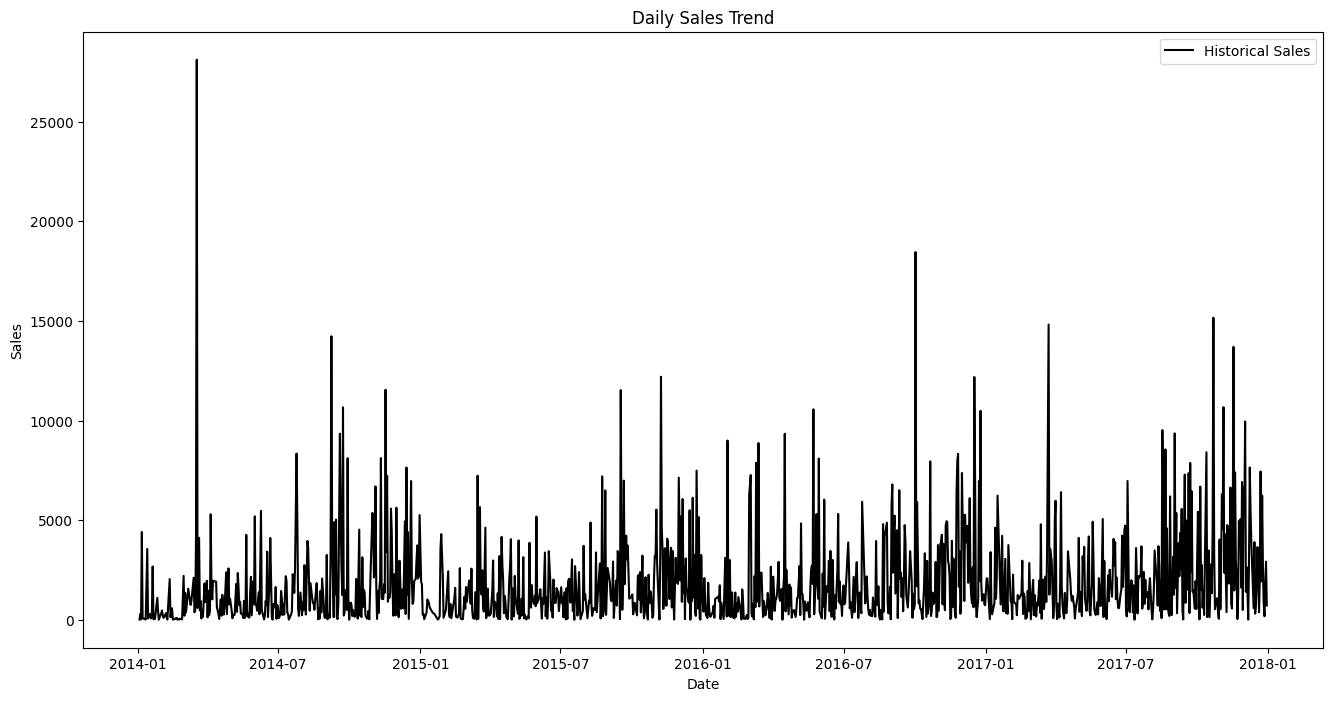

In [10]:
# Plot historical sales data
plt.figure(figsize=(16, 8))
plt.plot(df_sales['Order Date'], df_sales['Sales'], label='Historical Sales', color='black')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales Trend')
plt.legend()
plt.show()

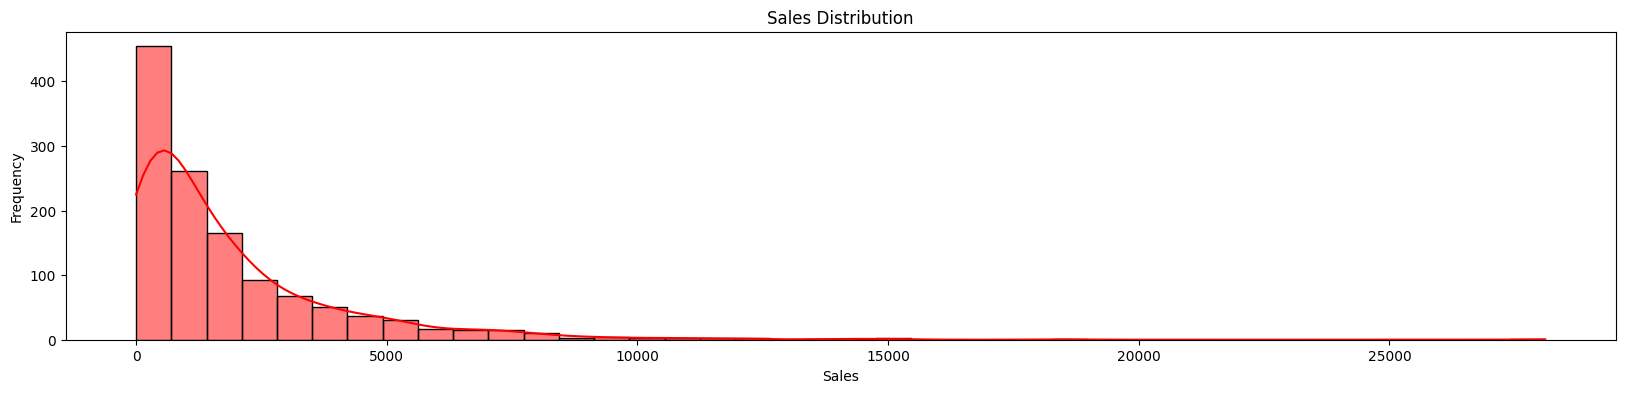

In [11]:
# Sales distribution plot 
plt.figure(figsize=(20, 4))
sns.histplot(df_sales['Sales'], bins=40, kde=True, color='red')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


In [12]:
# 3. Train a time series forecasting model using Exponential Smoothing
model = ExponentialSmoothing(df_sales['Sales'], trend='add', seasonal='add', seasonal_periods=30)
fitted_model = model.fit()

# Generate predictions for the next 30 days
future_dates = pd.date_range(start=df_sales['Order Date'].max(), periods=30, freq='D')
forecast_sales = fitted_model.forecast(30)

# Create a DataFrame for forecasted sales
forecast_df = pd.DataFrame({'Order Date': future_dates, 'Forecasted Sales': forecast_sales})

# Display the forecasted sales data
print("\nForecasted Sales Data:")
print(forecast_df.head())


Forecasted Sales Data:
     Order Date  Forecasted Sales
1237 2017-12-30       2824.697296
1238 2017-12-31       3065.816720
1239 2018-01-01       3706.253795
1240 2018-01-02       2725.219361
1241 2018-01-03       3725.760960


In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit a model with multiplicative trend and seasonality
model = ExponentialSmoothing(
    df_sales['Sales'], 
    trend='mul',  # Multiplicative trend
    seasonal='mul',  # Multiplicative seasonality
    seasonal_periods=30  # Seasonal cycle length
)
fitted_model = model.fit()

# Generate predictions for the next 30 days
future_dates = pd.date_range(start=df_sales['Order Date'].max(), periods=30, freq='D')
forecast_sales = fitted_model.forecast(30)

# Create a DataFrame for forecasted sales
forecast_df = pd.DataFrame({'Order Date': future_dates, 'Forecasted Sales': forecast_sales})

# Display the forecasted sales data
print("\nForecasted Sales Data (Multiplicative Model):")
print(forecast_df.head())


Forecasted Sales Data (Multiplicative Model):
     Order Date  Forecasted Sales
1237 2017-12-30       1440.263680
1238 2017-12-31       1649.144557
1239 2018-01-01       1944.476175
1240 2018-01-02       1460.278435
1241 2018-01-03       1919.025243


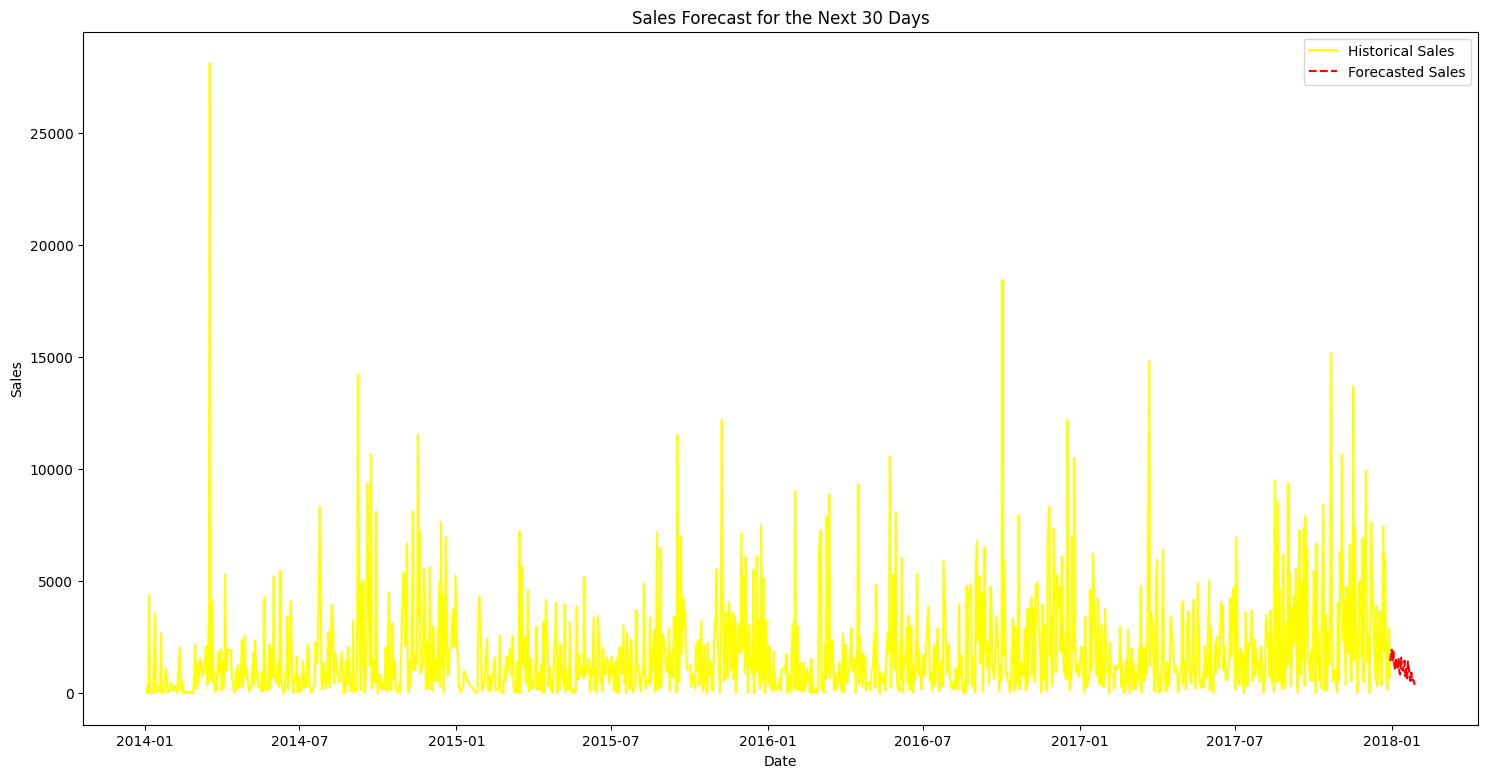

In [14]:
# Plot the forecasted sales
plt.figure(figsize=(18, 9))
plt.plot(df_sales['Order Date'], df_sales['Sales'], label='Historical Sales', color='yellow')
plt.plot(future_dates, forecast_sales, label='Forecasted Sales', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast for the Next 30 Days')
plt.legend()
plt.show()

In [15]:
# Split data into training and validation sets
train_size = int(len(df_sales) * 0.8)
train, test = df_sales[:train_size], df_sales[train_size:]

# Train model on training data
model_train = ExponentialSmoothing(train['Sales'], trend='mul', seasonal='mul', seasonal_periods=30)
fitted_train = model_train.fit()

# Make predictions on test data
test_predictions = fitted_train.forecast(len(test))

# Calculate evaluation metrics
mae = mean_absolute_error(test['Sales'], test_predictions)
mse = mean_squared_error(test['Sales'], test_predictions)
rmse = np.sqrt(mse)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 2335.0144213940443
Mean Squared Error (MSE): 11646280.569840504
Root Mean Squared Error (RMSE): 3412.6647315317255


USING A ARMA MODEL TO FIND TREAND AND SEASONALITY  

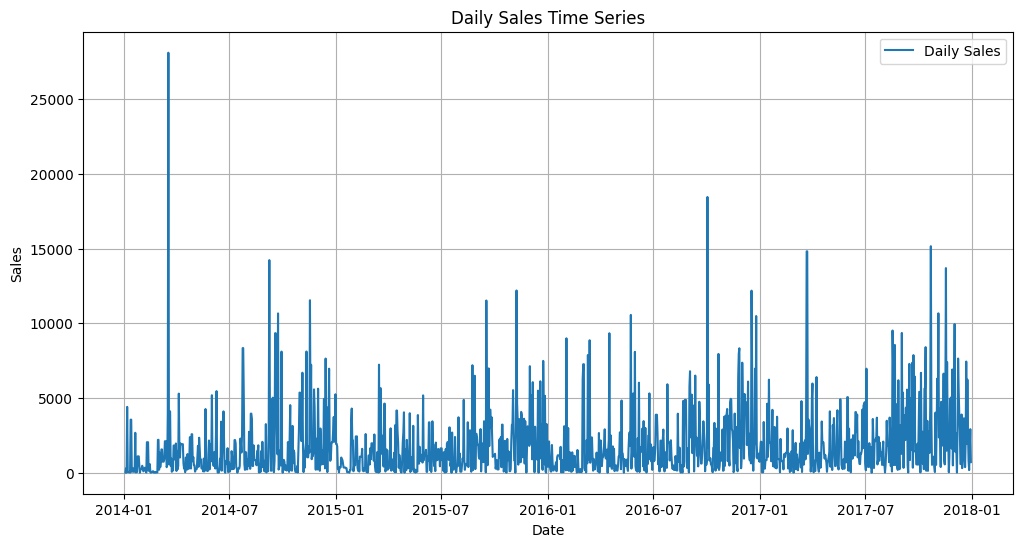

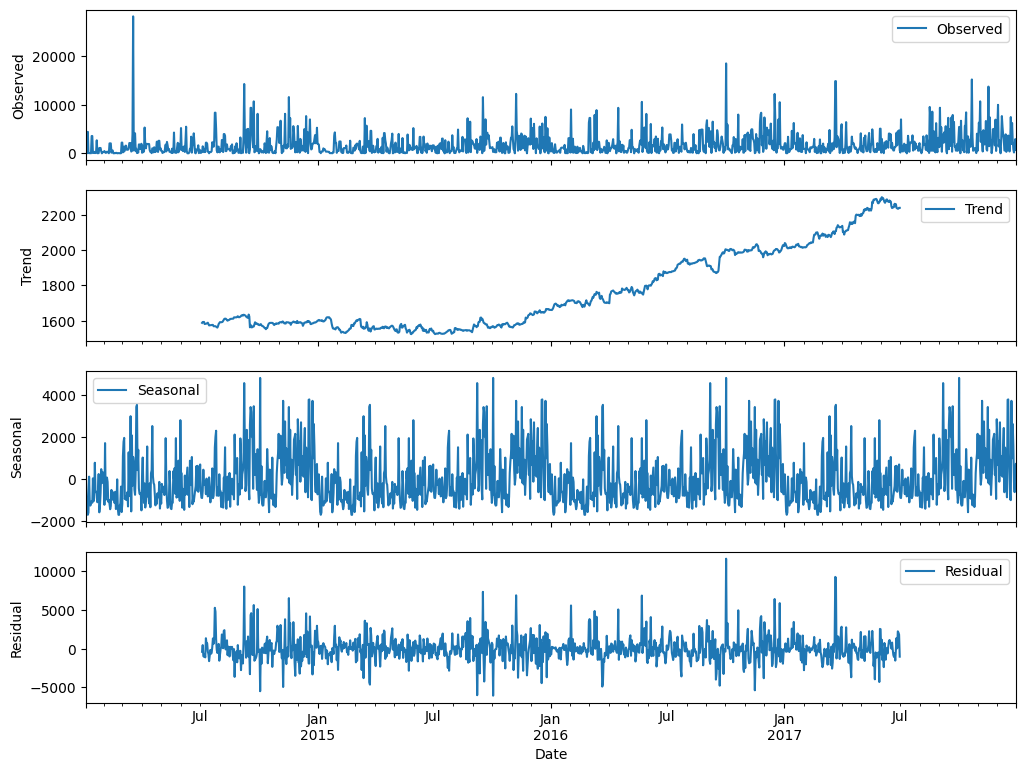

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import itertools

# Load the dataset
file_path = 'Sample - Superstore.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert 'Order Date' to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Aggregate sales data by date
daily_sales = data.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.set_index('Order Date', inplace=True)

# Fill missing values by interpolating and set the frequency to daily
daily_sales_filled = daily_sales.interpolate(method='linear').asfreq('D')

# Ensure there are no remaining missing values
daily_sales_filled = daily_sales_filled.fillna(method='bfill').fillna(method='ffill')

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_filled, label='Daily Sales')
plt.title('Daily Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(daily_sales_filled, model='additive', period=365)

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
decomposition.observed.plot(ax=axes[0], label='Observed', legend=True)
decomposition.trend.plot(ax=axes[1], label='Trend', legend=True)
decomposition.seasonal.plot(ax=axes[2], label='Seasonal', legend=True)
decomposition.resid.plot(ax=axes[3], label='Residual', legend=True)

axes[0].set_ylabel('Observed')
axes[1].set_ylabel('Trend')
axes[2].set_ylabel('Seasonal')
axes[3].set_ylabel('Residual')
plt.xlabel('Date')
plt.show()

ADF Statistic: -6.653299372022279
p-value: 5.057044276195288e-09
The time series is stationary (no trend).
Best ARMA Order: (2, 1) with AIC: 21111.877594790116

Improved Model Evaluation Metrics:
Mean Absolute Error (MAE): 1740.2755922725764
Mean Squared Error (MSE): 7289141.7420705985
Root Mean Squared Error (RMSE): 2699.841058668195


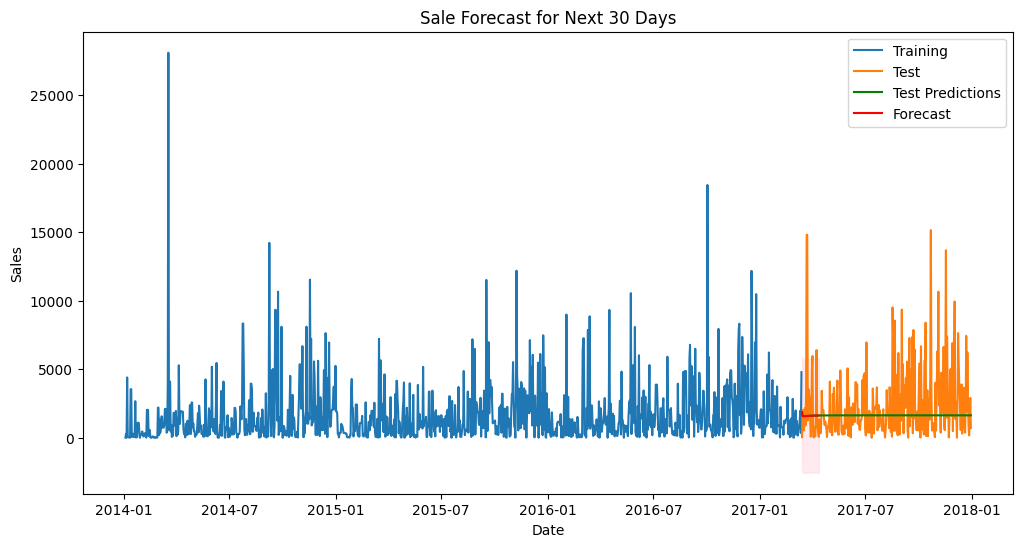

In [24]:

# Perform Augmented Dickey-Fuller test
result = adfuller(daily_sales_filled)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpretation of ADF test
if result[1] <= 0.05:
    print("The time series is stationary (no trend).")
else:
    print("The time series is non-stationary (has a trend).")

# Split data into training and validation sets
train_size = int(len(daily_sales_filled) * 0.8)
train, test = daily_sales_filled[:train_size], daily_sales_filled[train_size:]

# Define a range of p and q values to search
p_values = range(0, 3)
q_values = range(0, 3)

best_aic = float('inf')
best_order = (0, 0)
best_model = None

# Grid search for the best ARMA order
for p, q in itertools.product(p_values, q_values):
    try:
        model = ARIMA(train, order=(p, 0, q))
        fitted_model = model.fit()
        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_order = (p, q)
            best_model = fitted_model
    except:
        continue

print(f"Best ARMA Order: {best_order} with AIC: {best_aic}")

# Use the best model to forecast and evaluate
test_predictions = best_model.forecast(steps=len(test))
mae = mean_absolute_error(test, test_predictions)
mse = mean_squared_error(test, test_predictions)
rmse = np.sqrt(mse)

print("\nImproved Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Forecast future values (next 30 days)
forecast_steps = 30
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot the observed vs predicted values and the forecast
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(test.index, test_predictions, label='Test Predictions', color='green')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Sale Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


USING A ARIMA MODEL FOR FORCASTING NEXT 30 DAYS PREDICTION 

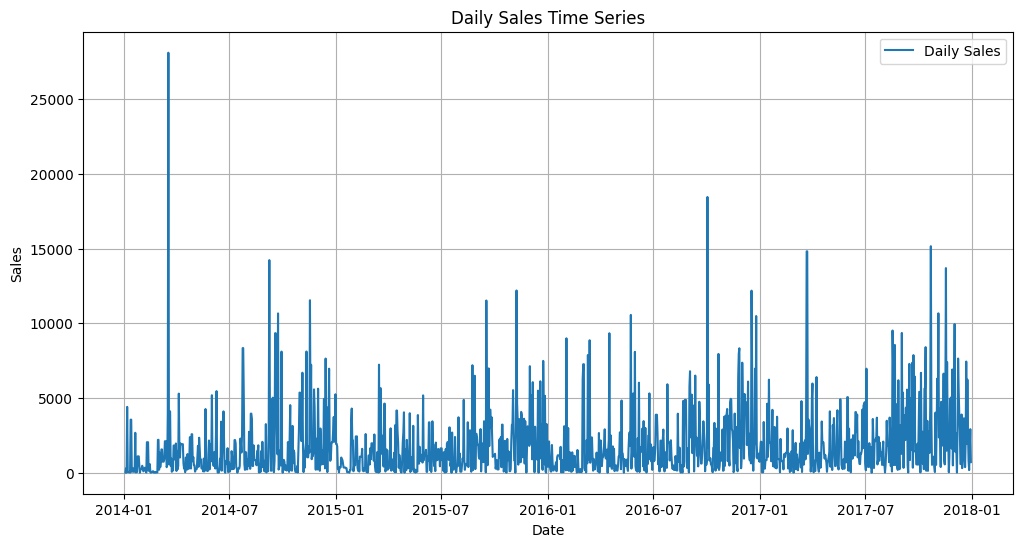

ADF Statistic: -6.653299372022279
p-value: 5.057044276195288e-09
The time series is stationary (no trend).

Model Evaluation Metrics:
Mean Absolute Error (MAE): 1753.3482485281372
Mean Squared Error (MSE): 7705175.123193877
Root Mean Squared Error (RMSE): 2775.819720946207


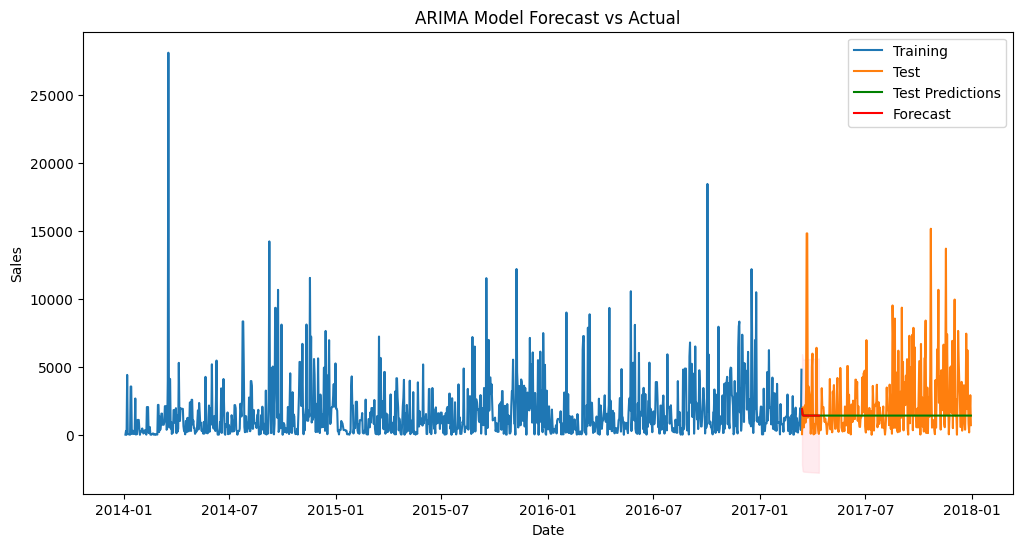

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the dataset
file_path = 'Sample - Superstore.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert 'Order Date' to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Aggregate sales data by date
daily_sales = data.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.set_index('Order Date', inplace=True)

# Fill missing values by interpolating and set the frequency to daily
daily_sales_filled = daily_sales.interpolate(method='linear').asfreq('D')

# Ensure there are no remaining missing values
daily_sales_filled = daily_sales_filled.fillna(method='bfill').fillna(method='ffill')

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_filled, label='Daily Sales')
plt.title('Daily Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

# Perform Augmented Dickey-Fuller test
result = adfuller(daily_sales_filled)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpretation of ADF test
if result[1] <= 0.05:
    print("The time series is stationary (no trend).")
else:
    print("The time series is non-stationary (has a trend).")

# Split data into training and validation sets
train_size = int(len(daily_sales_filled) * 0.8)
train, test = daily_sales_filled[:train_size], daily_sales_filled[train_size:]

# Fit ARIMA model on training data
# Since the data is stationary, we set d=0
order = (1, 1, 1)  # Example order, you may need to tune these parameters
model_train = ARIMA(train, order=order)
fitted_train = model_train.fit()

# Make predictions on test data
test_predictions = fitted_train.forecast(steps=len(test))

# Calculate evaluation metrics
mae = mean_absolute_error(test, test_predictions)
mse = mean_squared_error(test, test_predictions)
rmse = np.sqrt(mse)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Forecast future values (next 30 days)
forecast_steps = 30
forecast = fitted_train.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot the observed vs predicted values and the forecast
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(test.index, test_predictions, label='Test Predictions', color='green')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
